In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
# Thêm thư viện
import tensorflow as tf 
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50, ResNet50V2, DenseNet201, MobileNet, MobileNetV2
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, UpSampling2D, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras.datasets import cifar100, cifar10
from keras.utils import print_summary, to_categorical
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
# import os

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
BATCH_SIZE = 128
NUM_CLASSES = 100
EPOCHS = 100
INIT_DROPOUT_RATE = 0.4
MOMENTUM_RATE = 0.9
INIT_LEARNING_RATE = 0.1
L2_DECAY_RATE = 0.0005
CROP_SIZE = 32
MODEL_PATH = './checkpoint/cifar100_{epoch:02d}_.h5'

In [4]:
(list_image, labels), (x_test, y_test) = cifar100.load_data()
x_train, x_val, y_train, y_val = train_test_split(list_image, labels, test_size=0.2, random_state=42)

169009152/169001437 [==============================] - 2s 0us/step


In [5]:
datagen_train = ImageDataGenerator(rotation_range=15,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)


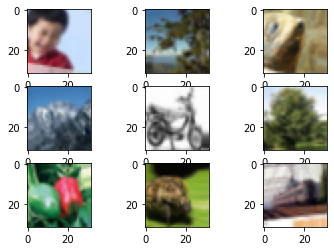

In [6]:
datagen_train.fit(x_train)

# see example augmentation images
for X_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break
# print(x_train[0])

In [7]:
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255.
x_val = x_val/255.
x_test = x_test/255.
print(x_train.shape, x_val.shape, x_test.shape)
# print(x_train[0])

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


In [8]:
baseModel = DenseNet201(include_top=False, weights='imagenet', input_shape=(128,128,3), classes=NUM_CLASSES)

74842112/74836368 [==============================] - 1s 0us/step


In [9]:
model = Sequential()
model.add(UpSampling2D((2,2)))
model.add(UpSampling2D((2,2)))
model.add(baseModel)
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
model.build((None, 32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) multiple                  0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 multiple                  0         
_________________________________________________________________
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  983552    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  5

In [10]:
model.layers[3].trainable = False

In [11]:
train_flow = datagen_train.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [12]:

opt = RMSprop(lr=0.0001, decay=1e-6)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', patience = 4, mode='min',
                        factor = 0.3, min_lr = 1e-8, verbose = 1)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
H = model.fit_generator(train_flow,
                    epochs=30,
                    steps_per_epoch=len(x_train) / BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    callbacks = [rlrop],
                    validation_steps=len(x_val) / BATCH_SIZE)

Train for 312.5 steps, validate on 10000 samples
Epoch 1/30
313/312 [==============================] - 197s 631ms/step - loss: 2.5063 - accuracy: 0.4062 - val_loss: 1.1525 - val_accuracy: 0.6819
Epoch 2/30
313/312 [==============================] - 139s 444ms/step - loss: 1.0528 - accuracy: 0.7058 - val_loss: 0.8907 - val_accuracy: 0.7483
Epoch 3/30
313/312 [==============================] - 139s 443ms/step - loss: 0.7235 - accuracy: 0.7919 - val_loss: 0.7517 - val_accuracy: 0.7891
Epoch 4/30
313/312 [==============================] - 139s 444ms/step - loss: 0.5361 - accuracy: 0.8417 - val_loss: 0.7404 - val_accuracy: 0.7981
Epoch 5/30
313/312 [==============================] - 138s 440ms/step - loss: 0.4108 - accuracy: 0.8751 - val_loss: 0.8155 - val_accuracy: 0.7899
Epoch 6/30
313/312 [==============================] - 138s 441ms/step - loss: 0.3261 - accuracy: 0.8994 - val_loss: 0.8538 - val_accuracy: 0.7938
Epoch 7/30
313/312 [==============================] - 138s 441ms/step - los

In [ ]:
# opt2 = Adam(lr=0.0001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# rlrop2 = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, mode='min',
#                         factor = 0.2, min_lr = 1e-7, verbose = 1)
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt2,
#               metrics=['accuracy'])

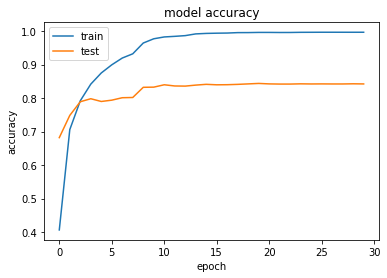

In [14]:
plothist(H)

In [15]:
model.save('densenet_cifar100.h5')

In [ ]:
score = model.evaluate(x_test, y_test)
print('accuracy: ',score[1])